# Imports

In [15]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.fft import rfft,rfftfreq
import librosa
import librosa.display
import IPython.display as ipd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

warnings.filterwarnings('ignore')

# Model

### define features extraction function

In [16]:
def mfcc_feature_extractor(audio,sampleRate):
    mfccsFeatures = librosa.feature.mfcc(y=audio, sr=sampleRate, n_mfcc=40)
    mfccsScaledFeatures = np.mean(mfccsFeatures.T,axis=0)
    
    return mfccsScaledFeatures

In [17]:
def contrast_feature_extractor(audio,sampleRate):
    stft = np.abs(librosa.stft(audio))
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sampleRate) 
    contrastScaled = np.mean(contrast.T,axis=0)
    
    return contrastScaled

In [18]:
def tonnetz_feature_extractor(audio,sampleRate):
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sampleRate)
    tonnetzScaled = np.mean(tonnetz.T,axis=0)
    
    return tonnetzScaled

In [19]:
def centroid_feature_extractor(audio,sampleRate):
    centroid = librosa.feature.spectral_centroid(y=audio,sr=sampleRate) 
    centroidScaled = np.mean(centroid.T,axis=0)
    
    return centroidScaled

In [20]:
def chroma_feature_extractor(audio,sampleRate):
    stft = np.abs(librosa.stft(audio))
    chroma = librosa.feature.chroma_stft(S=stft,sr=sampleRate)
    chromaScaled = np.mean(chroma.T,axis=0)
    
    return chromaScaled

In [21]:
def features_extractor(file):
    features=[]
    audio, sampleRate = librosa.load(file, res_type='kaiser_fast') 
    mfcc=mfcc_feature_extractor(audio,sampleRate)
    contrast = contrast_feature_extractor(audio,sampleRate)
    tonnetz = tonnetz_feature_extractor(audio,sampleRate)
    chroma = chroma_feature_extractor(audio,sampleRate)

    features.append([mfcc,contrast,tonnetz,chroma])
    features[0] = np.concatenate((features[0][0],features[0][1],features[0][2],features[0][3]))
    return features

### define add features function

In [22]:
def add_features(extractedFeatures,dirPath,label):
    for file in os.listdir(dirPath):
        filePath = dirPath+'/'+file
        finalClassLabels=label
        audio, sampleRate = librosa.load(filePath, res_type='kaiser_fast') 
        mfcc=mfcc_feature_extractor(audio,sampleRate)
        contrast = contrast_feature_extractor(audio,sampleRate)
        tonnetz = tonnetz_feature_extractor(audio,sampleRate)
        chroma = chroma_feature_extractor(audio,sampleRate)
        extractedFeatures.append([mfcc,contrast,tonnetz,chroma,finalClassLabels])

### creating dictionary with dirPath and label

In [23]:
dict = {"anwar":"C:/Users/EXTRA/DSP_Task3/backend/files/Anwar","aya":"C:/Users/EXTRA/DSP_Task3/backend/files/Aya","ehab":"C:/Users/EXTRA/DSP_Task3/backend/files/Ehab","zeyad":"C:/Users/EXTRA/DSP_Task3/backend/files/Zeyad"}

In [24]:
dict2 = {"anwar":"C:/Users/EXTRA/DSP_Task3/processing/anwar","aya":"C:/Users/EXTRA/DSP_Task3/processing/aya","ehab":"C:/Users/EXTRA/DSP_Task3/processing/ehab","zeyad":"C:/Users/EXTRA/DSP_Task3/processing/zeyad"}

In [25]:
dict3 = {"anwar":"C:/Users/EXTRA/DSP_Task3/processing/words/Anwar","aya":"C:/Users/EXTRA/DSP_Task3/processing/words/Aya","ehab":"C:/Users/EXTRA/DSP_Task3/processing/words/Ehab","zeyad":"C:/Users/EXTRA/DSP_Task3/processing/words/Zeyad"}

### creating data frame from our data

In [26]:
extractedFeatures = []
for i in dict.keys():
    add_features(extractedFeatures,dict[i],i)
for x in dict2.keys():
    add_features(extractedFeatures,dict2[x],x)
for y in dict3.keys():  
    add_features(extractedFeatures,dict3[y],y)

In [27]:
data=pd.DataFrame(extractedFeatures,columns=['mfcc','contrast','tonnetz','chroma','class'])
print(data.shape)
data.head()

(1127, 5)


,mfcc,contrast,tonnetz,chroma,class
0,"[-506.52463, 61.64891, 8.294457, 6.1529727, 16...","[18.225099789410645, 14.073347582034515, 14.92...","[-0.026156166403453775, -0.007522828056776607,...","[0.7895138, 0.7891665, 0.7331944, 0.69265306, ...",anwar
1,"[-484.83054, 57.63201, 19.381887, 17.619091, 1...","[20.11971653181864, 14.4055109778802, 15.14931...","[0.020898464482939905, 0.02311273234743904, 0....","[0.7711498, 0.77708644, 0.7428681, 0.6990656, ...",anwar
2,"[-375.71805, 95.867195, -0.665796, 31.796244, ...","[18.940401074917414, 15.716624572258736, 17.18...","[0.0030600953263598307, 0.004340534464086048, ...","[0.62990934, 0.66626626, 0.70043945, 0.7260682...",anwar
3,"[-351.94073, 53.247982, 12.9672785, 10.35929, ...","[18.990867307267536, 14.260342060954631, 16.18...","[-0.013442975463150214, -0.03099029914648438, ...","[0.7548545, 0.85651636, 0.81929094, 0.6672034,...",anwar
4,"[-442.27194, 81.52423, 17.646692, 13.475121, 1...","[20.260033821862628, 13.37880827112114, 15.661...","[-0.021241162685261376, -0.021280018761884012,...","[0.665574, 0.78218377, 0.7599841, 0.68303883, ...",anwar


### splitting the data into features and target

In [28]:
features=data.iloc[:,0:-1]
target=data['class']
features.head()

,mfcc,contrast,tonnetz,chroma
0,"[-506.52463, 61.64891, 8.294457, 6.1529727, 16...","[18.225099789410645, 14.073347582034515, 14.92...","[-0.026156166403453775, -0.007522828056776607,...","[0.7895138, 0.7891665, 0.7331944, 0.69265306, ..."
1,"[-484.83054, 57.63201, 19.381887, 17.619091, 1...","[20.11971653181864, 14.4055109778802, 15.14931...","[0.020898464482939905, 0.02311273234743904, 0....","[0.7711498, 0.77708644, 0.7428681, 0.6990656, ..."
2,"[-375.71805, 95.867195, -0.665796, 31.796244, ...","[18.940401074917414, 15.716624572258736, 17.18...","[0.0030600953263598307, 0.004340534464086048, ...","[0.62990934, 0.66626626, 0.70043945, 0.7260682..."
3,"[-351.94073, 53.247982, 12.9672785, 10.35929, ...","[18.990867307267536, 14.260342060954631, 16.18...","[-0.013442975463150214, -0.03099029914648438, ...","[0.7548545, 0.85651636, 0.81929094, 0.6672034,..."
4,"[-442.27194, 81.52423, 17.646692, 13.475121, 1...","[20.260033821862628, 13.37880827112114, 15.661...","[-0.021241162685261376, -0.021280018761884012,...","[0.665574, 0.78218377, 0.7599841, 0.68303883, ..."


In [29]:
# mfcc=np.array(features['mfcc'].tolist())
# contrast = np.array(features['contrast'].tolist())
# tonnetz = np.array(features['tonnetz'].tolist())
# chroma = np.array(features['chroma'].tolist())

In [30]:
# features=[]
# for i in range(len(mfcc)):
#     features.append(mfcc[i])
# data=pd.DataFrame(features)
features = features.values.tolist()
for i in range(len(features)):
    features[i] = np.concatenate((features[i][0],features[i][1],features[i][2],features[i][3]))

### encoding the target

In [31]:
encoder = LabelEncoder()
target = encoder.fit_transform(target)

### splitting the data into train and test

In [32]:
xTrain, xTest, yTrain, yTest = train_test_split(features, target, test_size=0.25, random_state=0)

### creating SVM model

In [33]:
classifier= SVC(kernel='linear',decision_function_shape="ovo") 
classifier.fit(xTrain,yTrain)

SVC(decision_function_shape='ovo', kernel='linear')

### predicting xTest

In [34]:
preds = classifier.predict(xTest)

In [85]:
# from matplotlib import pyplot as plt
# from sklearn import svm


# def f_importances(coef, names):
#     imp = coef
#     imp, names = zip(*sorted(zip(imp, names)))
#     plt.barh(range(len(names)), imp, align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()


# features_names = ['input1', 'input2']
# svm = svm.SVC(kernel='linear')
# svm.fit(xTrain, yTrain)
# f_importances(svm.coef_, features_names)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [50]:
def prediction(pred):
    if pred==0:
        print("anwar")
    elif pred==1:
        print("aya")
    elif pred==2:
        print("ehab")
    elif pred==3:
        print("zeyad")

### making classification report to see the result of the predicton 

In [51]:
print(classification_report(yTest,preds))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.99      1.00      0.99        70
           2       0.97      0.99      0.98        73
           3       0.99      0.97      0.98        68

    accuracy                           0.98       282
   macro avg       0.98      0.98      0.98       282
weighted avg       0.98      0.98      0.98       282



In [53]:
testFeatures = features_extractor("C:/Users/EXTRA/DSP_Task3/processing/words/Aya/voice01100741.wav")
pred = classifier.predict(testFeatures)
prediction(pred)


aya


### creating pickle

In [54]:
pickle_out = open("model.pkl", "wb")
pickle.dump(classifier, pickle_out)
pickle_out.close()

In [88]:
# svr = SVC(C=10, cache_size=200, class_weight='auto', coef0=0.0, degree=3.0, gamma=0.12, kernel='linear',
#           max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001, verbose=False)
# clf = svr.fit(xTrain, yTrain)
# print(clf.coef_)


ValueError: class_weight must be dict, 'balanced', or None, got: 'auto'

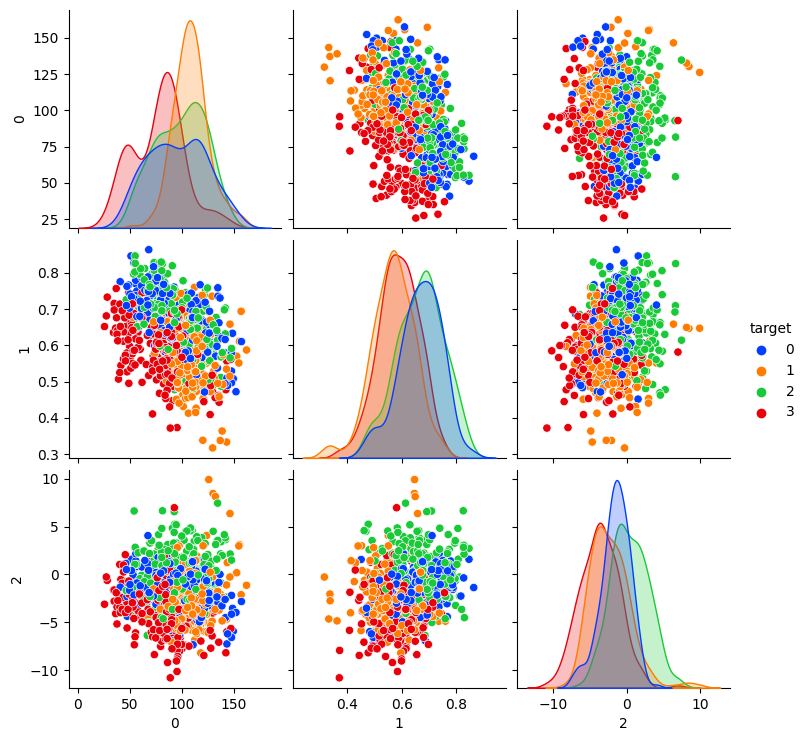

In [171]:

xtrainNew = []
for i in xTrain:
    xtrainNew.append([i[1],  i[23]])
    # xtrainNew.append([i[1], i[55], i[23]])
xtrainNew = np.array(xtrainNew)
import seaborn as sns
model_data = pd.DataFrame(xtrainNew)
model_data["target"] = yTrain
sns.pairplot(model_data, hue="target",palette="bright")

# most clear 1 23 33 
# less 34 35 37 63
#1 56 23 (23 with 56 seems good)
# 1 55 23 (23 with 55 seems good)
